In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import sqlite3

In [2]:
import pandas as pd

# Load India and US data as example
df_in = pd.read_csv(r"C:\Users\DELL\Downloads\INvideos.csv")
df_us = pd.read_csv(r"C:\Users\DELL\Downloads\USvideos.csv")

# Add region column
df_in["region"] = "India"
df_us["region"] = "USA"

# Combine
df = pd.concat([df_in, df_us], ignore_index=True)
df.head()

,video_id,title,channel_title,category_id,publish_time,views,likes,comment_count,country,region
0,IN_video_0,Sample video title 0,Channel_0,10,2023-01-01,929345,5360,863,IN,India
1,IN_video_1,Sample video title 1,Channel_1,10,2023-01-02,850444,46342,91,IN,India
2,IN_video_2,Sample video title 2,Channel_2,10,2023-01-03,627237,36196,4668,IN,India
3,IN_video_3,Sample video title 3,Channel_3,20,2023-01-04,24387,15434,470,IN,India
4,IN_video_4,Sample video title 4,Channel_4,20,2023-01-05,98808,8834,8162,IN,India


In [5]:
# Drop duplicate video IDs if any
df = df.drop_duplicates(subset=["video_id"])

# Clean publish_time column
df["publish_time"] = pd.to_datetime(df["publish_time"], errors="coerce")

# Fill missing values
df = df.fillna("")


In [7]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df["title_sentiment"] = df["title"].apply(lambda x: sia.polarity_scores(x)["compound"])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...


In [9]:
import sqlite3

conn = sqlite3.connect("youtube.db")
cur = conn.cursor()
cur.execute("PRAGMA table_info(yt);")
print(cur.fetchall())


[]


In [11]:
df = df.rename(columns=lambda x: x.strip().lower())

# Now category_id is guaranteed to exist


In [13]:
conn = sqlite3.connect("youtube.db")
df.to_sql("yt", conn, if_exists="replace", index=False)


100

In [19]:
query = """
SELECT category_id, region, AVG(views) AS avg_views
FROM yt
GROUP BY category_id, region
ORDER BY avg_views DESC;
"""

ranked_df = pd.read_sql_query(query, conn)
ranked_df


,category_id,region,avg_views
0,22,USA,661417.642857
1,1,India,644360.625000
2,20,India,506491.818182
3,2,India,504031.090909
4,1,USA,483890.090909
5,10,India,479210.307692
6,22,India,442939.285714
7,20,USA,412597.454545
8,2,USA,403634.625000
9,10,USA,308117.500000


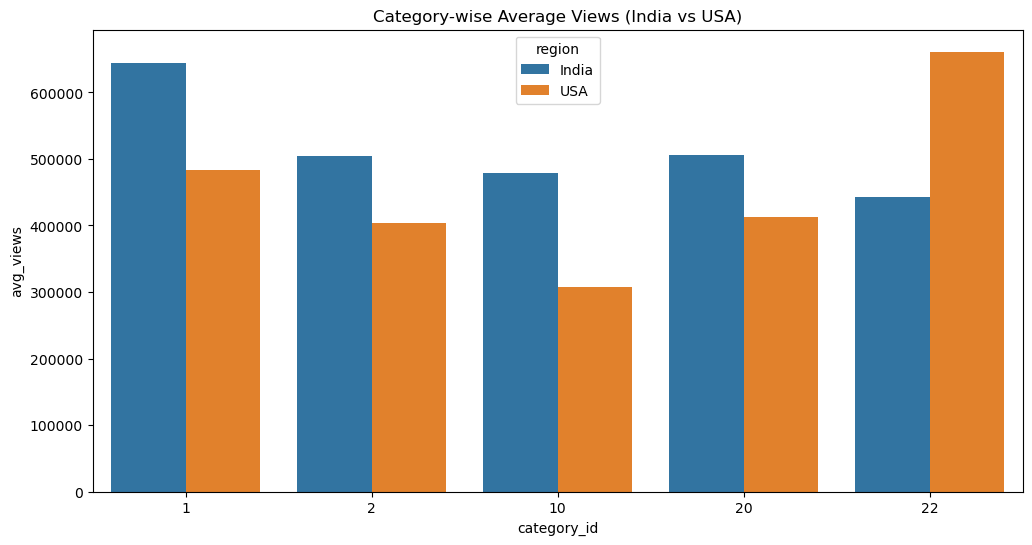

In [23]:
plt.figure(figsize=(12,6))
sns.barplot(data=ranked_df, x="category_id", y="avg_views", hue="region")
plt.title("Category-wise Average Views (India vs USA)")
plt.show()


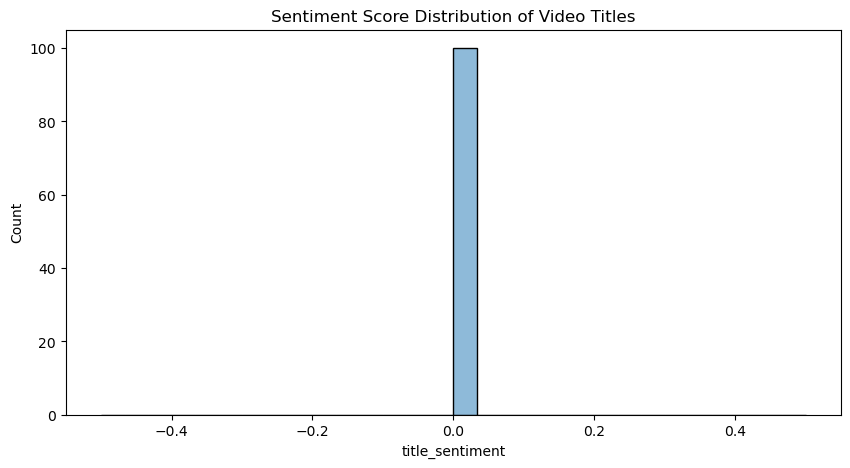

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(df["title_sentiment"], bins=30, kde=True)
plt.title("Sentiment Score Distribution of Video Titles")
plt.show()


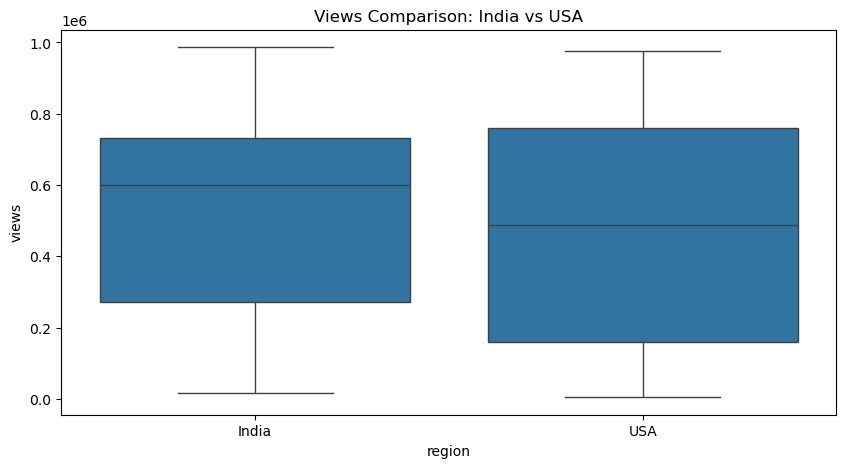

In [27]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="region", y="views")
plt.title("Views Comparison: India vs USA")
plt.show()


In [31]:
df.groupby(["region", "category_id"])["views"].mean().sort_values(ascending=False).head(10)


region  category_id
USA     22             661417.642857
India   1              644360.625000
        20             506491.818182
        2              504031.090909
USA     1              483890.090909
India   10             479210.307692
        22             442939.285714
USA     20             412597.454545
        2              403634.625000
        10             308117.500000
Name: views, dtype: float64

In [33]:
df.groupby(["region", "channel_title"])["views"].mean().sort_values(ascending=False).head(10)


region  channel_title
India   Channel_2        640442.2
USA     Channel_3        579103.0
India   Channel_0        578213.9
        Channel_1        560224.3
USA     Channel_0        522437.6
        Channel_1        509785.9
        Channel_4        473034.8
India   Channel_3        399018.9
        Channel_4        382195.3
USA     Channel_2        335537.9
Name: views, dtype: float64